## 필요 모듈 불러오기

In [11]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as np

import tensorflow_datasets as tfds

from sklearn.preprocessing import LabelBinarizer

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
# 데이터셋 다운로드
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

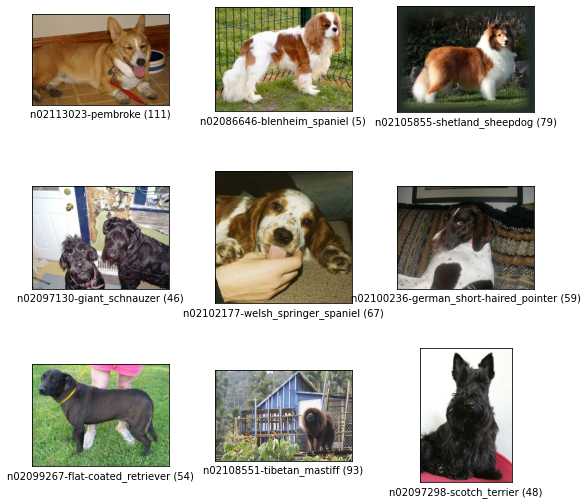

In [15]:
# 예제 확인
fig = tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )   
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Make the Random Augmentation

In [17]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

## Cutmix

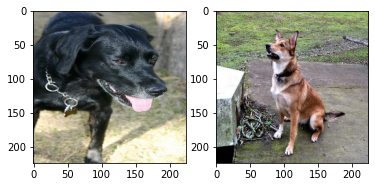

In [18]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [19]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(154, shape=(), dtype=int32) tf.Tensor(143, shape=(), dtype=int32)


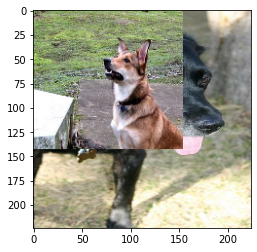

In [20]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [21]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5611049 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [22]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.5611049  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.43889508 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

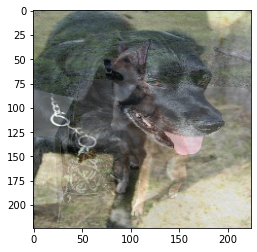

In [23]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [24]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2. 모델 만들기

In [25]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [28]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 3. 모델 훈련하기

In [30]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 124s 166ms/step - loss: 2.2082 - accuracy: 0.4482 - val_loss: 3.5968 - val_accuracy: 0.1702
Epoch 2/20
750/750 [==============================] - 123s 164ms/step - loss: 0.7772 - accuracy: 0.7799 - val_loss: 1.0667 - val_accuracy: 0.6799
Epoch 3/20
750/750 [==============================] - 125s 167ms/step - loss: 0.3040 - accuracy: 0.9273 - val_loss: 0.9891 - val_accuracy: 0.7120
Epoch 4/20
750/750 [==============================] - 122s 163ms/step - loss: 0.1148 - accuracy: 0.9845 - val_loss: 0.9370 - val_accuracy: 0.7315
Epoch 5/20
750/750 [==============================] - 121s 161ms/step - loss: 0.0568 - accuracy: 0.9953 - val_loss: 0.9402 - val_accuracy: 0.7350
Epoch 6/20
750/750 [==============================] - 121s 161ms/step - loss: 0.0347 - accuracy: 0.9974 - val_loss: 0.9214 - val_accuracy: 0.7451
Epoch 7/20
750/750 [==============================] - 121s 162ms/step - loss: 0.0213 - accuracy: 0.9975 - val_loss: 0.9427 -

750/750 [==============================] - 128s 171ms/step - loss: 2.2510 - accuracy: 0.4335 - val_loss: 3.1917 - val_accuracy: 0.2464
Epoch 2/20
750/750 [==============================] - 128s 170ms/step - loss: 0.9326 - accuracy: 0.7310 - val_loss: 1.1512 - val_accuracy: 0.6655
Epoch 3/20
750/750 [==============================] - 128s 170ms/step - loss: 0.4967 - accuracy: 0.8627 - val_loss: 1.1145 - val_accuracy: 0.6817
Epoch 4/20
750/750 [==============================] - 128s 171ms/step - loss: 0.3069 - accuracy: 0.9216 - val_loss: 1.0613 - val_accuracy: 0.6980
Epoch 5/20
750/750 [==============================] - 132s 176ms/step - loss: 0.1352 - accuracy: 0.9755 - val_loss: 0.9736 - val_accuracy: 0.7232
Epoch 6/20
750/750 [==============================] - 128s 171ms/step - loss: 0.1006 - accuracy: 0.9822 - val_loss: 1.0686 - val_accuracy: 0.7053
Epoch 7/20
750/750 [==============================] - 128s 170ms/step - loss: 0.0526 - accuracy: 0.9927 - val_loss: 0.9396 - val_accura

750/750 [==============================] - 127s 169ms/step - loss: 3.8285 - accuracy: 0.2138 - val_loss: 3.4851 - val_accuracy: 0.1934
Epoch 2/20
750/750 [==============================] - 127s 169ms/step - loss: 2.9489 - accuracy: 0.4287 - val_loss: 1.4637 - val_accuracy: 0.5904
Epoch 3/20
750/750 [==============================] - 127s 169ms/step - loss: 2.6761 - accuracy: 0.5189 - val_loss: 1.3446 - val_accuracy: 0.6150
Epoch 4/20
750/750 [==============================] - 127s 169ms/step - loss: 2.4708 - accuracy: 0.5803 - val_loss: 1.3828 - val_accuracy: 0.6312
Epoch 5/20
750/750 [==============================] - 127s 169ms/step - loss: 2.3102 - accuracy: 0.6301 - val_loss: 1.1235 - val_accuracy: 0.6883
Epoch 6/20
750/750 [==============================] - 127s 169ms/step - loss: 2.1991 - accuracy: 0.6739 - val_loss: 1.2189 - val_accuracy: 0.6700
Epoch 7/20
750/750 [==============================] - 127s 169ms/step - loss: 2.1222 - accuracy: 0.6980 - val_loss: 1.2010 - val_accura

750/750 [==============================] - 126s 168ms/step - loss: 3.7363 - accuracy: 0.2333 - val_loss: 3.9316 - val_accuracy: 0.1264
Epoch 2/20
750/750 [==============================] - 126s 169ms/step - loss: 2.8822 - accuracy: 0.4677 - val_loss: 1.6655 - val_accuracy: 0.5431
Epoch 3/20
750/750 [==============================] - 126s 168ms/step - loss: 2.5928 - accuracy: 0.5790 - val_loss: 1.5921 - val_accuracy: 0.5688
Epoch 4/20
750/750 [==============================] - 126s 168ms/step - loss: 2.4011 - accuracy: 0.6551 - val_loss: 1.2406 - val_accuracy: 0.6549
Epoch 5/20
750/750 [==============================] - 126s 168ms/step - loss: 2.2921 - accuracy: 0.6927 - val_loss: 1.2760 - val_accuracy: 0.6502
Epoch 6/20
750/750 [==============================] - 126s 168ms/step - loss: 2.1853 - accuracy: 0.7390 - val_loss: 1.1660 - val_accuracy: 0.6798
Epoch 7/20
750/750 [==============================] - 126s 168ms/step - loss: 2.0912 - accuracy: 0.7691 - val_loss: 1.2702 - val_accura

## 4. 훈련 과정 시각화하기

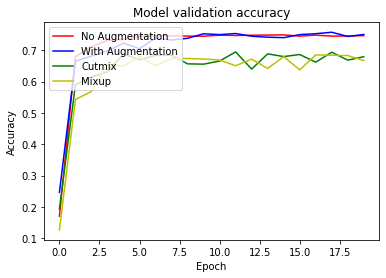

In [31]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.show()

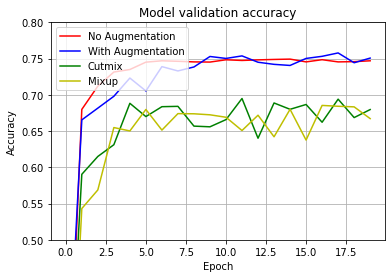

In [34]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)     
# plt.ylim(0.72, 0.76)   
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

#### -20에폭밖에 학습을 안시켜서 그런지는 모르겠으나 Cutmix나 Mixup을 적용시킨 모델이 그렇지 않은 모델보다 정확도가 대략 7~8% 가량 낮게 나오는 것 같다.   
#### -에폭 수를 늘리거나 데이터셋을 변경하면 Cutmix나 Mixup 모델이 더 좋은 성능을 낼 수 있을거라 예상해본다